Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, \
StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, \
plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, \
roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bootstrap_point632_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.inspection import permutation_importance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **1. Load the Combined Drug Data**

In [2]:
tsv_file='drugsComTrain_raw.tsv'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('Data1.csv',index=False)
Data1 = pd.read_csv("Data1.csv")
print(Data1.shape)
Data1.head()

 ## Import DrugsComTest Data Set 
  
tsv_file='drugsComTest_raw.tsv'
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('Data2.csv',index=False)
Data2 = pd.read_csv("Data2.csv")
print(Data2.shape)
Data2.head()


drug = pd.concat([Data1,Data2], ignore_index=True)


(161297, 7)
(53766, 7)


## **2. Exploratory Data Analysis**


#### **Data Cleaning**



In [3]:
drug.shape

(215063, 7)

In [4]:
#check for duplicates
drug.duplicated().sum()

0

***Our focus is using the text data to prdict the drug rating***

In [5]:
data = drug[['review', 'rating']]
data.head(2)

,review,rating
0,"""It has no side effect, I take it in combinati...",9.0
1,"""My son is halfway through his fourth week of ...",8.0


In [6]:
#Check for Null values
data.isna().sum()

review    0
rating    0
dtype: int64

In [7]:
data['rating'].unique()

array([ 9.,  8.,  5.,  2.,  1., 10.,  4.,  3.,  7.,  6.])

Text(0.5, 1.0, 'Rating Distribution')

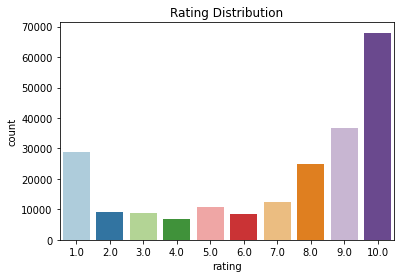

In [8]:
#Plot rating distribution
sns.countplot(x = data['rating'], palette = "Paired")
plt.title("Rating Distribution")

***Combine rating in two positive, neutral and negative***

In [9]:
# Categorize reviews into positive, negative, or neutral 
data.loc[(data['rating'] > 6), 'review_sentiment'] = 'Positive' 
data.loc[(data['rating'] < 5), 'review_sentiment'] = 'Negative' 
data.loc[((data['rating'] >= 5) & (data['rating'] <=6)  ),         
                                                'review_sentiment'] = 'Neutral' 
data['review_sentiment'].value_counts()

Positive    142306
Negative     53572
Neutral      19185
Name: review_sentiment, dtype: int64

In [10]:
data.head()

,review,rating,review_sentiment
0,"""It has no side effect, I take it in combinati...",9.0,Positive
1,"""My son is halfway through his fourth week of ...",8.0,Positive
2,"""I used to take another oral contraceptive, wh...",5.0,Neutral
3,"""This is my first time using any form of birth...",8.0,Positive
4,"""Suboxone has completely turned my life around...",9.0,Positive


***Neutral class are not helpful in this case, so we drop it***

In [11]:
#Drop neutral value
data.drop(data[data['review_sentiment']=='Neutral'].index, inplace = True)
data.reset_index(drop=True, inplace=True)
data['review_sentiment'].value_counts()

Positive    142306
Negative     53572
Name: review_sentiment, dtype: int64

In [12]:
data['review_sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [13]:
data.head()

,review,rating,review_sentiment
0,"""It has no side effect, I take it in combinati...",9.0,Positive
1,"""My son is halfway through his fourth week of ...",8.0,Positive
2,"""This is my first time using any form of birth...",8.0,Positive
3,"""Suboxone has completely turned my life around...",9.0,Positive
4,"""2nd day on 5mg started to work with rock hard...",2.0,Negative


In [14]:
data = data.dropna()

Text(0.5, 1.0, 'Review Sentiment Distribution')

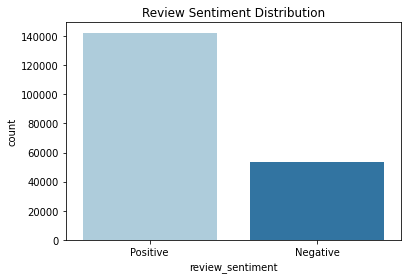

In [15]:
#Plot Review_Sentiment distribution
sns.countplot(x = data['review_sentiment'], palette = "Paired")
plt.title("Review Sentiment Distribution")

In [16]:
data['review_sentiment'].value_counts(normalize=True)

Positive    0.726503
Negative    0.273497
Name: review_sentiment, dtype: float64

*--> The review sentiment seems to be imbalance, but not too bad.*

***Cleaning review text***

In [17]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [18]:
data['review_clean'] = review_clean(data['review'])
data.head(8)

,review,rating,review_sentiment,review_clean
0,"""It has no side effect, I take it in combinati...",9.0,Positive,it has no side effect i take it in combination...
1,"""My son is halfway through his fourth week of ...",8.0,Positive,my son is halfway through his fourth week of i...
2,"""This is my first time using any form of birth...",8.0,Positive,this is my first time using any form of birth ...
3,"""Suboxone has completely turned my life around...",9.0,Positive,suboxone has completely turned my life around ...
4,"""2nd day on 5mg started to work with rock hard...",2.0,Negative,2nd day on 5mg started to work with rock hard ...
5,"""He pulled out, but he cummed a bit in me. I t...",1.0,Negative,he pulled out but he cummed a bit in me i took...
6,"""Abilify changed my life. There is hope. I was...",10.0,Positive,abilify changed my life there is hope i was on...
7,""" I Ve had nothing but problems with the Kepp...",1.0,Negative,i ve had nothing but problems with the keppera...


In [19]:
from nltk.corpus import stopwords
#Removing the stopwords
stop_words = set(stopwords.words('english'))
data['review_clean'] = data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [20]:
data.head(8)

,review,rating,review_sentiment,review_clean
0,"""It has no side effect, I take it in combinati...",9.0,Positive,side effect take combination bystolic 5 mg fis...
1,"""My son is halfway through his fourth week of ...",8.0,Positive,son halfway fourth week intuniv became concern...
2,"""This is my first time using any form of birth...",8.0,Positive,first time using form birth control im glad we...
3,"""Suboxone has completely turned my life around...",9.0,Positive,suboxone completely turned life around feel he...
4,"""2nd day on 5mg started to work with rock hard...",2.0,Negative,2nd day 5mg started work rock hard erections h...
5,"""He pulled out, but he cummed a bit in me. I t...",1.0,Negative,pulled cummed bit took plan b 26 hours later t...
6,"""Abilify changed my life. There is hope. I was...",10.0,Positive,abilify changed life hope zoloft clonidine fir...
7,""" I Ve had nothing but problems with the Kepp...",1.0,Negative,nothing problems keppera constant shaking arms...


In [21]:
data.isna().sum()

review              0
rating              0
review_sentiment    0
review_clean        0
dtype: int64

## **Training/test Split**

In [22]:
#Set data frame for predictor and target variable
X= data[['review_clean']]
y= data[['review_sentiment']]
# Encode Review_Sentiment
y['review_sentiment']= pd.DataFrame(LabelEncoder().fit_transform(y))
y.head()

#Split the data into train (80%) and test (20%), random state= 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42)
y_train.head(2)

,review_sentiment
194752,1
74017,1


In [23]:
#Overview of the text on the train data
X_train.describe()

,review_clean
count,156702
unique,105891
top,good
freq,107


***Feature Enginerring***

In [24]:
#transform text data usign TF-IDF 
spmat= TfidfVectorizer(analyzer='word',stop_words= 'english', max_features=5000) #Remove stop words
matrix = spmat.fit_transform(X_train['review_clean'])
X_testvec = spmat.transform(X_test['review_clean'])
# Create a new dataframe with column names
feat_names= spmat.get_feature_names_out()
X_trainvec= pd.DataFrame.sparse.from_spmatrix(matrix, columns=feat_names)
X_testvec= pd.DataFrame.sparse.from_spmatrix(X_testvec, columns=feat_names)
X_trainvec.head()

,00,000,00am,00pm,01,02,04,05,06,07,...,zoloft,zolpidem,zombie,zomig,zone,zovia,zubsolv,zyban,zyprexa,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Here we see the Nans
y_train.shape

(156702, 1)

In [26]:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
#y_train

## **4. Modeling**

In [27]:
# Create function to return model results

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

**Decision Tree**

In [ ]:
#test
#create standard tree for all words
dtree_model= tree.DecisionTreeClassifier(random_state=42)  
dtree_model = dtree_model.fit(X_trainvec, y_train)
y_pred_tree = dtree_model.predict(X_testvec)
print('standard tree accuracy %2.2f ' % accuracy_score(y_test,y_pred_tree))
print(classification_report(y_test,y_pred_tree))

standard tree accuracy 0.91 
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     10613
           1       0.94      0.93      0.94     28563

    accuracy                           0.91     39176
   macro avg       0.88      0.88      0.88     39176
weighted avg       0.91      0.91      0.91     39176



In [ ]:
cf_matrixtree = confusion_matrix(y_test, y_pred_tree)

print(cf_matrixtree)

[[ 8851  1762]
 [ 1885 26678]]


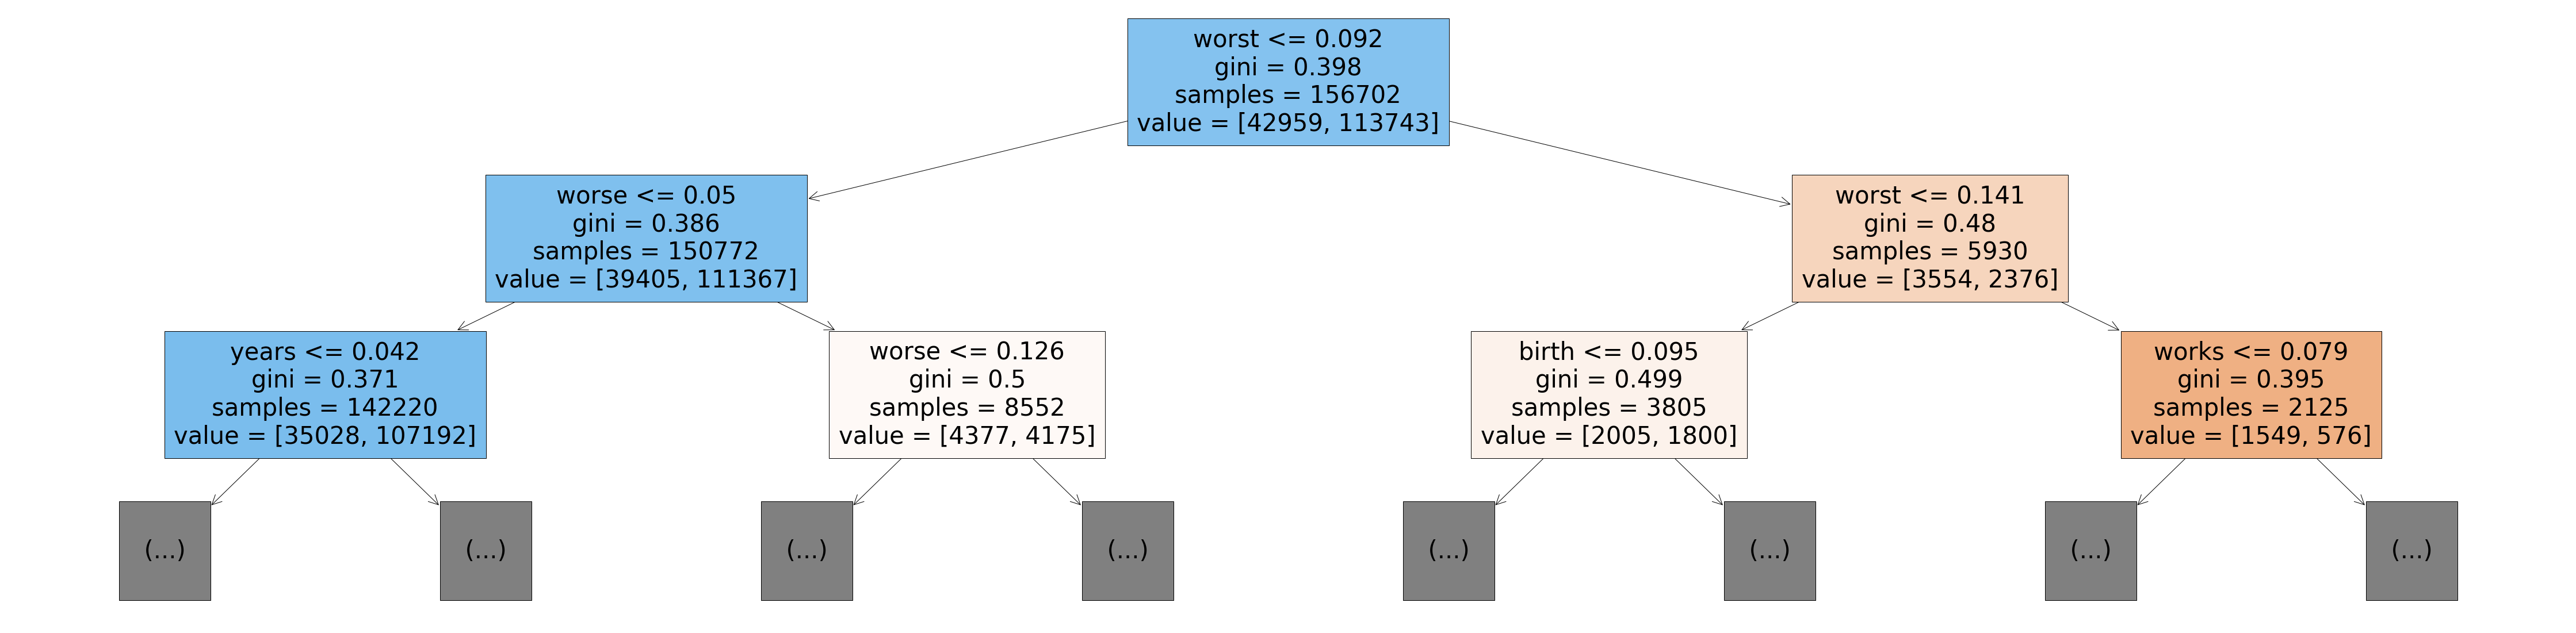

In [ ]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtree_model, feature_names=X_trainvec.columns, max_depth=2, filled=True);

In [ ]:
#Print depth of the model tree
dtree_model.tree_.max_depth

712

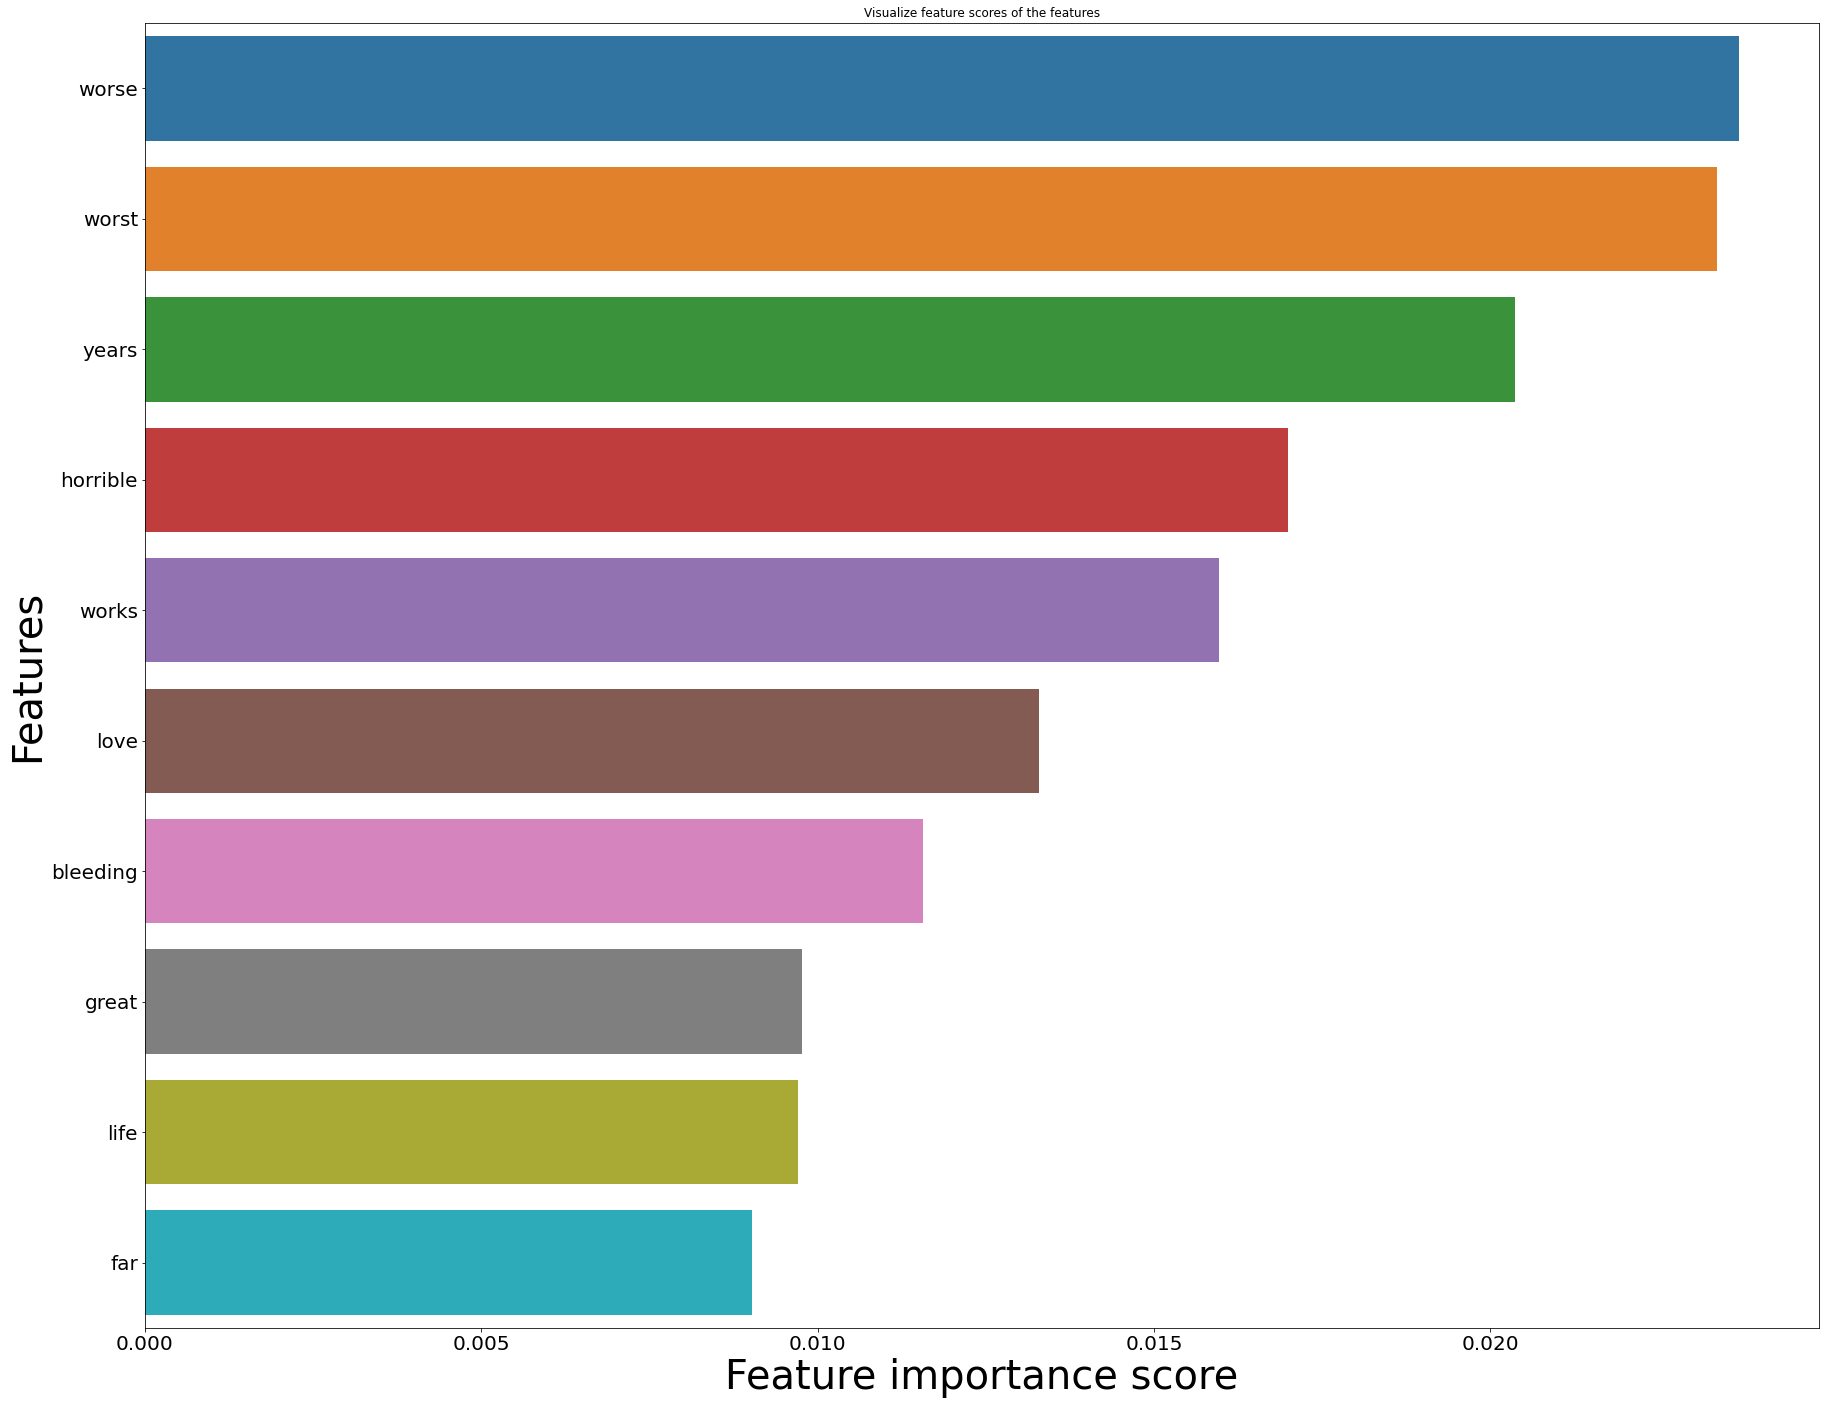

In [ ]:
from sklearn.inspection import permutation_importance
#Feature importance
feature_scores_all = pd.Series(dtree_model.feature_importances_,
                               index= X_trainvec.columns).sort_values(ascending=False)
#Select most important 10 feature
features_mask = pd.DataFrame(feature_scores_all).iloc[:10,:]
# Bar plot of feature importance
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=(features_mask.iloc[:,0]), y=features_mask.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(features_mask.index)
ax.set_xlabel("Feature importance score", fontsize = 40)
ax.set_ylabel("Features", fontsize = 40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
#Tuning
tune = [50,200,400,600]
result = []
for i in tune:
  dtree = tree.DecisionTreeClassifier(max_depth= i, random_state=42)
  dtree.fit(X_trainvec, y_train)
  dtreecv = cross_val_score(dtree , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
  dtreecv_mean = dtreecv.mean()

  result.append({'max_depth': i, 'Train Accuracy': dtreecv_mean,'Test Accuracy': dtree.score(X_testvec, y_test)})
print(result)

[{'max_depth': 50, 'Train Accuracy': 0.8289683329190705, 'Test Accuracy': 0.8485807637328977}, {'max_depth': 200, 'Train Accuracy': 0.8665237166066735, 'Test Accuracy': 0.898177455585052}, {'max_depth': 400, 'Train Accuracy': 0.8705696046170349, 'Test Accuracy': 0.9060394118848274}, {'max_depth': 600, 'Train Accuracy': 0.8700080284908497, 'Test Accuracy': 0.9052225852562793}]


In [ ]:
result= pd.DataFrame(result)
result

,max_depth,Train Accuracy,Test Accuracy
0,50,0.828968,0.848581
1,200,0.866524,0.898177
2,400,0.870570,0.906039
3,600,0.870008,0.905223


In [ ]:
Final_dtree_model= tree.DecisionTreeClassifier(random_state=42, max_depth = 200)  # Best Tuned Model
Final_dtree_model = Final_dtree_model.fit(X_trainvec, y_train)
y_pred_tree_final = Final_dtree_model.predict(X_testvec)
print('standard tree accuracy %2.2f ' % accuracy_score(y_test,y_pred_tree_final))
print(classification_report(y_test,y_pred_tree_final))

standard tree accuracy 0.90 
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     10613
           1       0.93      0.93      0.93     28563

    accuracy                           0.90     39176
   macro avg       0.87      0.87      0.87     39176
weighted avg       0.90      0.90      0.90     39176



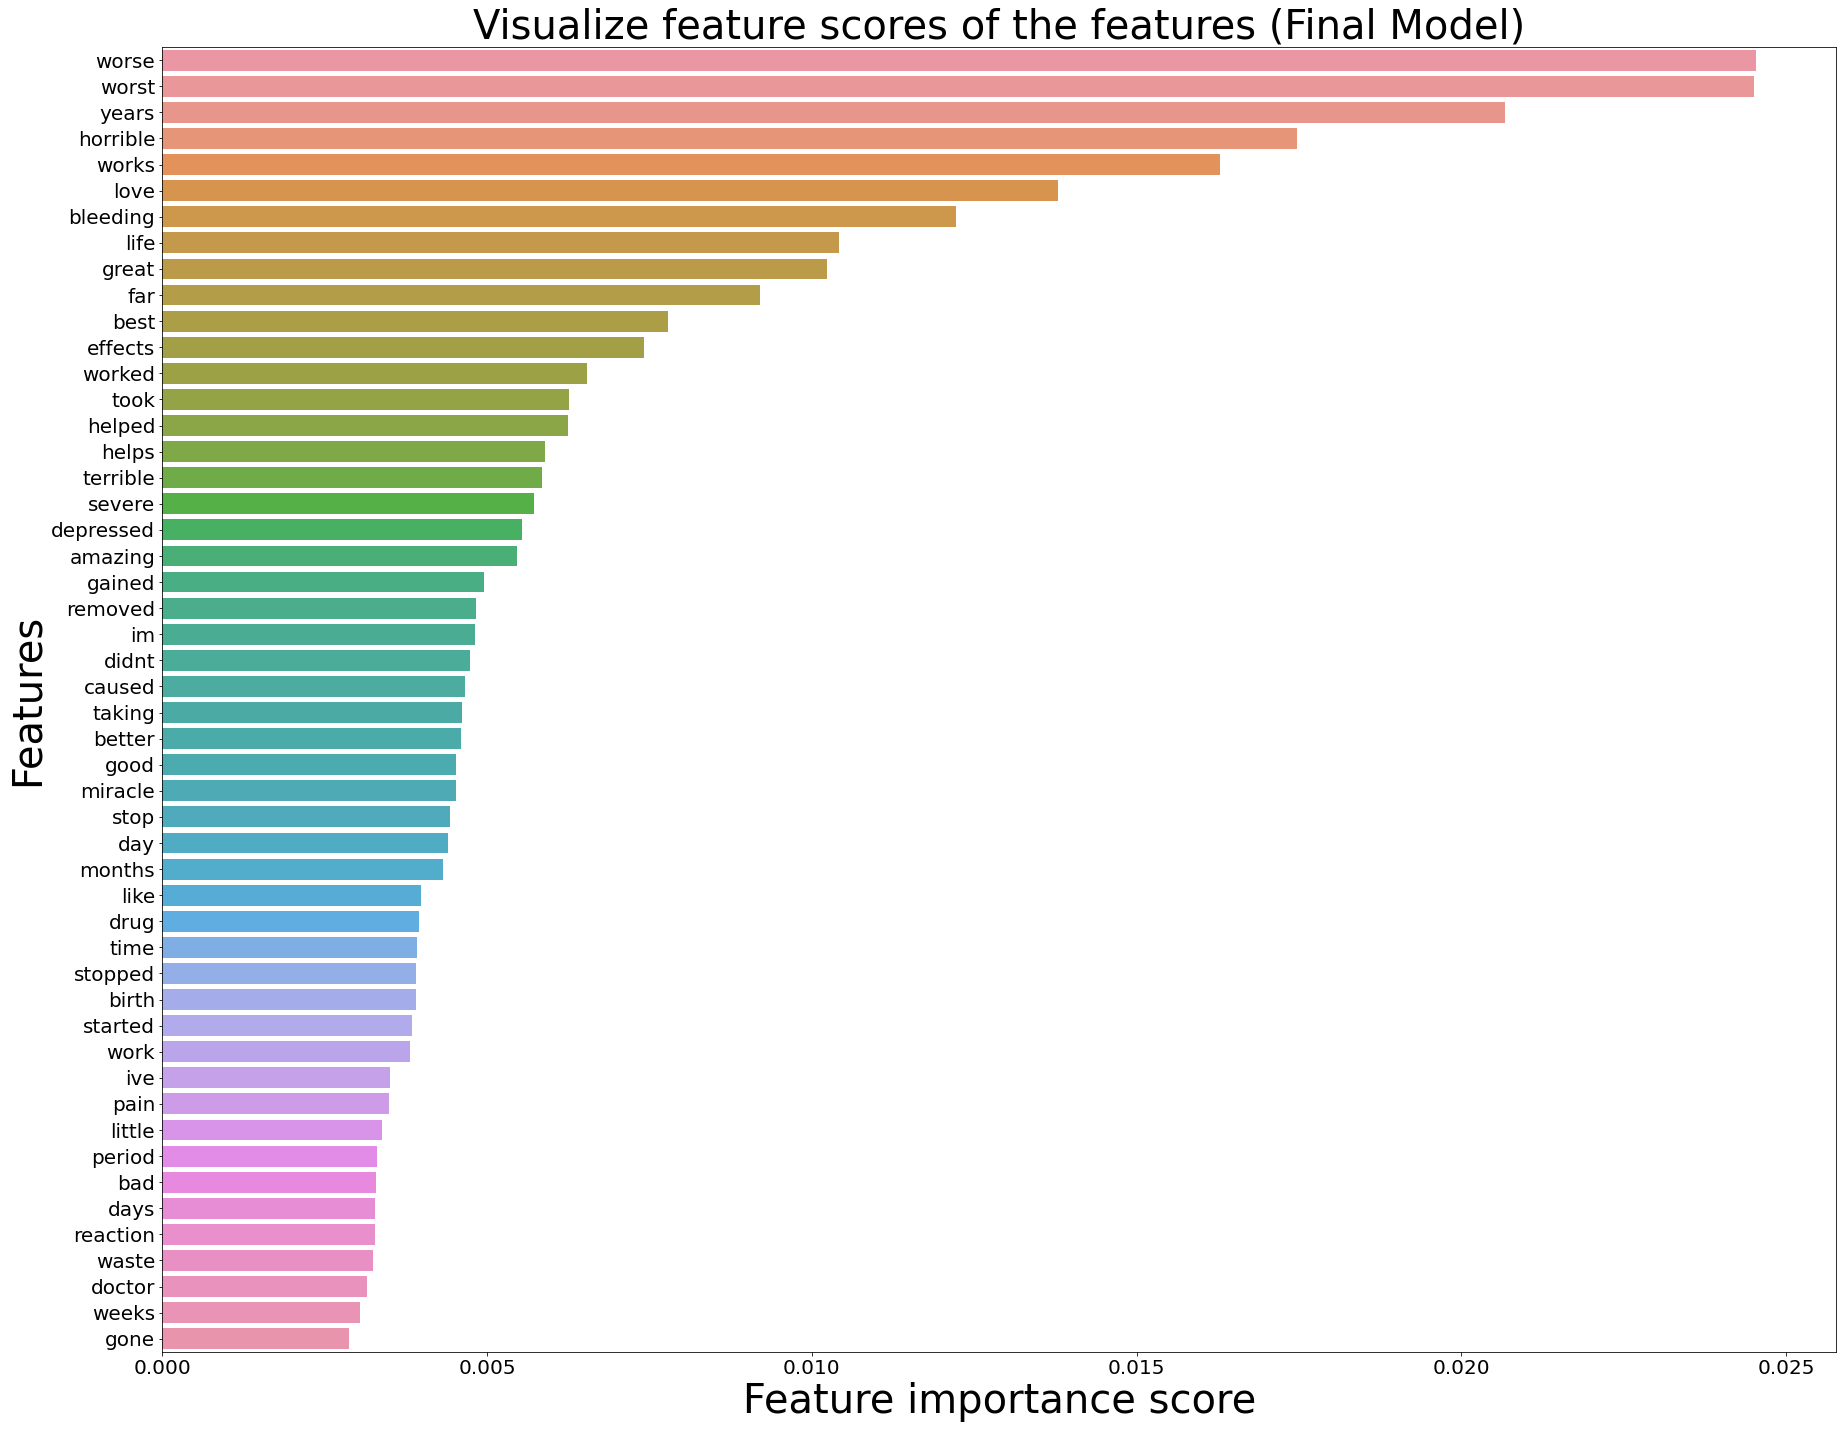

In [ ]:
#Feature importance
feature_scores_all = pd.Series(Final_dtree_model.feature_importances_,
                               index= X_trainvec.columns).sort_values(ascending=False)
#Select most important 10 feature
features_mask = pd.DataFrame(feature_scores_all).iloc[:50,:]
# Bar plot of feature importance
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=(features_mask.iloc[:,0]), y=features_mask.index)
ax.set_title("Visualize feature scores of the features (Final Model)",fontsize = 40)
ax.set_yticklabels(features_mask.index)
ax.set_xlabel("Feature importance score", fontsize = 40)
ax.set_ylabel("Features", fontsize = 40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

**Logistic, SVM, and Perceptron**

In [ ]:
#Loop to run logistic, svm, and perceptron
loss_f = ['log', 'hinge', 'perceptron']
sgdclfs = [SGDClassifier(loss=loss, random_state=42).fit(X_trainvec, y_train) for loss in loss_f]
scores_list = []
avg_list = []
#Create different method with both 5-cv and boostrap632
for i, loss in enumerate(loss_f):
  cv = cross_val_score(sgdclfs[i], X_trainvec, y_train, cv=5, scoring= 'accuracy') 
  scores_list.append({'Model': loss, 'Cross Validation': cv})              
  avg_list.append({'Model': loss, 'Average Cross Validation': cv.mean()})

In [ ]:
pd.DataFrame(avg_list)

,Model,Average Cross Validation
0,log,0.838075
1,hinge,0.851476
2,perceptron,0.807616


In [28]:
#Use SVM model
l1clf = SGDClassifier(loss='hinge', random_state=42)
l1clf = l1clf.fit(X_trainvec, y_train)
y_pred_hinge = l1clf.predict(X_testvec)
print('Hinge Model Accuracy: %2.2f ' % accuracy_score(y_test,y_pred_hinge ))
print(classification_report(y_test,y_pred_hinge ))

Hinge Model Accuracy: 0.85 
              precision    recall  f1-score   support

           0       0.82      0.57      0.67     10613
           1       0.86      0.96      0.90     28563

    accuracy                           0.85     39176
   macro avg       0.84      0.76      0.79     39176
weighted avg       0.85      0.85      0.84     39176



In [29]:
#Use perceptron model
l2clf = SGDClassifier(loss='perceptron', random_state=42)
l2clf = l1clf.fit(X_trainvec, y_train)
y_pred_per = l2clf.predict(X_testvec)
print('Perceptron Model Accuracy ' % accuracy_score(y_test,y_pred_per))
print(classification_report(y_test,y_pred_per ))

Perceptron Model Accuracy 
              precision    recall  f1-score   support

           0       0.82      0.57      0.67     10613
           1       0.86      0.96      0.90     28563

    accuracy                           0.85     39176
   macro avg       0.84      0.76      0.79     39176
weighted avg       0.85      0.85      0.84     39176



In [30]:
#Use Log model
l3clf = SGDClassifier(loss='log', random_state=42)
l3clf = l3clf.fit(X_trainvec, y_train)
y_pred_log = l1clf.predict(X_testvec)
print('Perceptron Model Accuracy ' % accuracy_score(y_test,y_pred_log))
print(classification_report(y_test,y_pred_log ))

Perceptron Model Accuracy 
              precision    recall  f1-score   support

           0       0.82      0.57      0.67     10613
           1       0.86      0.96      0.90     28563

    accuracy                           0.85     39176
   macro avg       0.84      0.76      0.79     39176
weighted avg       0.85      0.85      0.84     39176



**Logistic Regression- SGD Classifier - Log Loss, L1 and L2 Regularization**

In [ ]:
#Log Loss, L1 Regularization
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
result = []
for a in alphas:
  #Classifier with loss='log', penalty='l1', alpha=a, Then fit it on X and y
  l1clf = SGDClassifier(loss='log', penalty='l1', alpha=a, random_state=42).fit(X_trainvec, y_train)
  print('Finished training, alpha=%f' % a)
  # Compute cross_val_score for l1clf, cv=5, scoring='accuracy' and mean
  l1cv = cross_val_score(l1clf , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
  l1_acc_mean = l1cv.mean()
  print('Finished 5-fold CV, alpha=%f' % a)
  result.append({'alpha': a, 'log L1': l1_acc_mean})


Finished training, alpha=0.000010
Finished 5-fold CV, alpha=0.000010
Finished training, alpha=0.000100
Finished 5-fold CV, alpha=0.000100
Finished training, alpha=0.001000
Finished 5-fold CV, alpha=0.001000
Finished training, alpha=0.010000
Finished 5-fold CV, alpha=0.010000
Finished training, alpha=0.100000
Finished 5-fold CV, alpha=0.100000
Finished training, alpha=1.000000
Finished 5-fold CV, alpha=1.000000


In [ ]:
l1_acc = pd.DataFrame(result)
l1_acc

,alpha,log L1
0,0.00001,0.860091
1,0.00010,0.828764
2,0.00100,0.740112
3,0.01000,0.725855
4,0.10000,0.725855
5,1.00000,0.725855


In [ ]:
#Log Loss, L2 Regularization
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
result = []
for a in alphas:
  #Classifier with loss='log', penalty='l2', alpha=a, Then fit it on X and y
  l2clf = SGDClassifier(loss='log', penalty='l2', alpha=a, random_state=42).fit(X_trainvec, y_train)
  print('Finished training, alpha=%f' % a)
  # Compute cross_val_score for l1clf, cv=5, scoring='accuracy' and mean
  l2cv = cross_val_score(l2clf , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
  l2_acc_mean = l2cv.mean()
 # print('Finished 5-fold CV, alpha=%f' % a)
  result.append({'alpha': a, 'log L2': l2_acc_mean})


Finished training, alpha=0.000010
Finished training, alpha=0.000100
Finished training, alpha=0.001000
Finished training, alpha=0.010000
Finished training, alpha=0.100000
Finished training, alpha=1.000000


In [ ]:
l2_acc = pd.DataFrame(result)
l2_acc

,alpha,log L2
0,0.00001,0.860723
1,0.00010,0.838075
2,0.00100,0.738848
3,0.01000,0.725855
4,0.10000,0.725855
5,1.00000,0.725855


L1/L2 Accuracy Plot

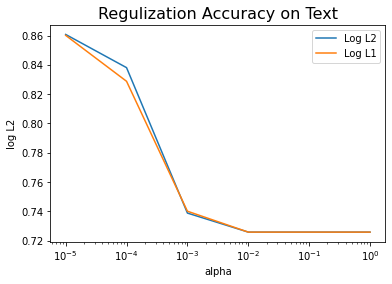

In [ ]:
#Plot accuracy of L1 and L2 models
sns.lineplot(l2_acc['alpha'], l2_acc['log L2'])
sns.lineplot((l1_acc['alpha']), l1_acc['log L1'])
plt.title('Regulization Accuracy on Text', size=16)
plt.legend(labels=["Log L2","Log L1"])
plt.xscale('log')
plt.show()

*--> Seems like the logistic regression doesn't need regularizaton. A regular logistic regression method could be used*

In [ ]:
#Use Logistic model with no reguliztion
l1clf = SGDClassifier(loss='log', penalty='l1', alpha=0.00001, random_state=42)
l1clf = l1clf.fit(X_trainvec, y_train)
y_pred_log = l1clf.predict(X_testvec)
print('standard tree accuracy %2.2f ' % accuracy_score(y_test,y_pred_log ))
print(classification_report(y_test,y_pred_log ))

standard tree accuracy 0.86 
              precision    recall  f1-score   support

           0       0.78      0.67      0.72     10613
           1       0.88      0.93      0.91     28563

    accuracy                           0.86     39176
   macro avg       0.83      0.80      0.81     39176
weighted avg       0.86      0.86      0.86     39176



In [ ]:
calculate_results(y_test,y_pred_log)

{'accuracy': 86.060343067184,
 'f1': 0.8570364398053675,
 'precision': 0.8566981362912787,
 'recall': 0.8606034306718399}

In [ ]:
l1cv = cross_val_score(l1clf , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
print(l1cv)

[0.86047031 0.8590664  0.85893427 0.85973197 0.86225271]


**Select KBest**

In [ ]:
#feature selection
#Univariate feature selection
kbest = SelectKBest(chi2, k=10)
X_new= kbest.fit_transform(X_trainvec, y_train)
print('Top 10 features %s' % X_trainvec.columns[kbest.get_support()].tolist())

Top 10 features ['best', 'bleeding', 'great', 'horrible', 'love', 'terrible', 'works', 'worse', 'worst', 'years']


In [ ]:
k_vals = [10,25,50,100,250,500,1000,5000]
results1 = []
for k in k_vals:
    kbest = SelectKBest(chi2, k=k)
    X_new = kbest.fit_transform(X_trainvec, y_train)
    perc = Perceptron().fit(X_new, y_train)
    train_acc = np.mean(cross_val_score(perc, X_new, y_train, cv=5, scoring='accuracy'))
    # Test Accuracy using kbest features from training
    Xtest_new = kbest.transform(X_testvec)
    test_acc = np.mean(cross_val_score(perc, Xtest_new, y_test, cv=5, scoring='accuracy'))

    results1.append({'k-value': k, 'Training Accuracy': train_acc, 'Test Accuracy':test_acc})

In [ ]:
results1_df = pd.DataFrame(results1)
results1_df

,k-value,Training Accuracy,Test Accuracy
0,10,0.733469,0.561415
1,25,0.655347,0.598145
2,50,0.735970,0.727690
3,100,0.745504,0.728865
4,250,0.759422,0.751582
5,500,0.783608,0.771237
6,1000,0.798292,0.788263
7,5000,0.815676,0.796891


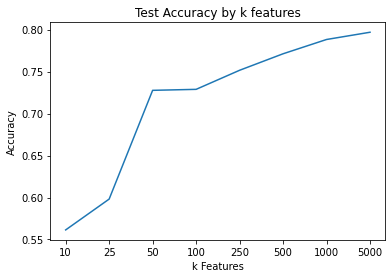

In [ ]:
plt.plot(results1_df['Test Accuracy'])
plt.title('Test Accuracy by k features')
plt.xlabel('k Features')
plt.ylabel('Accuracy')
plt.xticks(range(len(k_vals)), k_vals)
plt.show();

In [ ]:
kbest = SelectKBest(chi2, k=5000)
X_new= kbest.fit_transform(X_trainvec, y_train)
perc = Perceptron().fit(X_new, y_train)
y_predKbest = perc.predict(X_testvec)
cf_matrixKbest = confusion_matrix(y_test, y_predKbest)

print(cf_matrixKbest)

[[ 6665  3948]
 [ 3270 25293]]


In [ ]:
kbestreecv = cross_val_score(perc , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
print(kbestreecv)

[0.81436457 0.81229061 0.81263561 0.82137843 0.817709  ]


In [ ]:
calculate_results(y_test,y_predKbest)

{'accuracy': 81.57545435981213,
 'f1': 0.8137954045514426,
 'precision': 0.8123949424243453,
 'recall': 0.8157545435981213}

In [ ]:
print('KNN/Perceptron Accuracy: %2.2f ' % accuracy_score(y_test,y_predKbest))

KNN/Perceptron Accuracy: 0.82 


**Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# initializaing the NB
classifer = BernoulliNB()

# training the model
classifer.fit(X_trainvec, y_train)

# testing the model
y_predNB = classifer.predict(X_testvec)

print('Naive Bayes Accuracy %2.2f ' % accuracy_score(y_test,y_predNB))

Naive Bayes Accuracy 0.82 


In [ ]:
#cf_matrix Bernoulli Naive Bayes 

cf_matrixNB = confusion_matrix(y_test, y_predNB)
print(cf_matrixNB)

[[ 7729  2884]
 [ 4074 24489]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

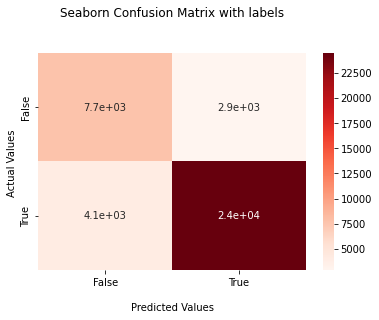

In [ ]:
#Naive Bayes Confusion Matrix
import seaborn as sns

ax = sns.heatmap(cf_matrixNB, annot=True, cmap='Reds')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [ ]:
calculate_results(y_test,y_predNB)

{'accuracy': 82.23912599550745,
 'f1': 0.8252163727009926,
 'precision': 0.8296755807906638,
 'recall': 0.8223912599550746}

**KNN Classifier**

In [ ]:
#KNN Model Classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_trainvec, y_train)
y_pred2 = neigh.predict(X_testvec)

In [ ]:
y_pred2 = neigh.predict(X_testvec)

In [ ]:
print('KNN Accuracy: %2.2f ' % accuracy_score(y_test,y_pred2))

KNN Accuracy: 0.74 


In [ ]:
neighcv = cross_val_score(neigh , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
print(neighcv)

[0.73220382 0.66778341 0.66442246 0.66305041 0.66678366]


In [ ]:
#Confusion Matrix 
cf_matrixKNN = confusion_matrix(y_test, y_pred2)
print(cf_matrixKNN)

[[10091   522]
 [ 9492 19071]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

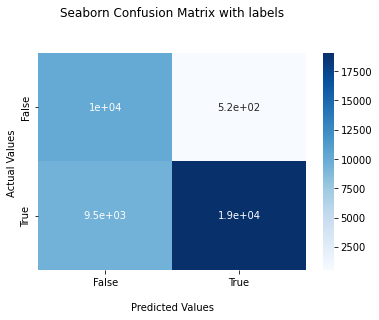

In [ ]:
#KNN Confusion Matrix


ax = sns.heatmap(cf_matrixKNN, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [ ]:
calculate_results(y_test,y_pred2)

{'accuracy': 74.43843169287318,
 'f1': 0.7585440952168544,
 'precision': 0.8492657155449553,
 'recall': 0.7443843169287319}

**ADA Boost Classifier**

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

# ADAboost model
modelADA = AdaBoostClassifier()
modelADA.fit(X_trainvec, y_train)
y_pred1 = modelADA.predict(X_testvec)

In [ ]:
print('ADA Boost Accuracy: %2.2f ' % accuracy_score(y_test,y_pred1))

ADA Boost Accuracy: 0.79 


In [ ]:
adacv = cross_val_score(modelADA , X_trainvec, y_train, cv=5, scoring= 'accuracy', 
                         n_jobs= 2)
print(adacv)

[0.79059379 0.78947704 0.78828973 0.78723676 0.79033184]


In [ ]:
#cf_matrix ADA Boost

cf_matrixADA = confusion_matrix(y_test, y_pred1)
print(cf_matrixADA)

[[ 4491  6122]
 [ 2103 26460]]


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

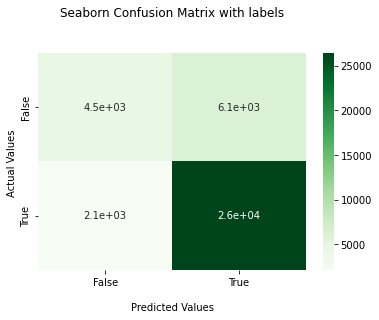

In [ ]:
#ADA Boost Confusion Matrix 

ax = sns.heatmap(cf_matrixADA, annot=True, cmap='Greens')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [ ]:
calculate_results(y_test,y_pred1)

{'accuracy': 79.00500306309985,
 'f1': 0.7724311625998657,
 'precision': 0.7766077662127545,
 'recall': 0.7900500306309985}

Top Words

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.015, wspace=0.90, hspace=0.3)
    plt.show()


In [ ]:
Vectorizer= CountVectorizer(analyzer='word',stop_words= 'english')
spmat1 = Vectorizer.fit_transform(X_train['review_clean'])
feat_names1= Vectorizer.get_feature_names_out()

In [ ]:
lda1 = LatentDirichletAllocation(
             n_components=10,
             max_iter=5,
             learning_method="online",
             learning_offset=50.0,
             random_state=0,)
lda1.fit(spmat1)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

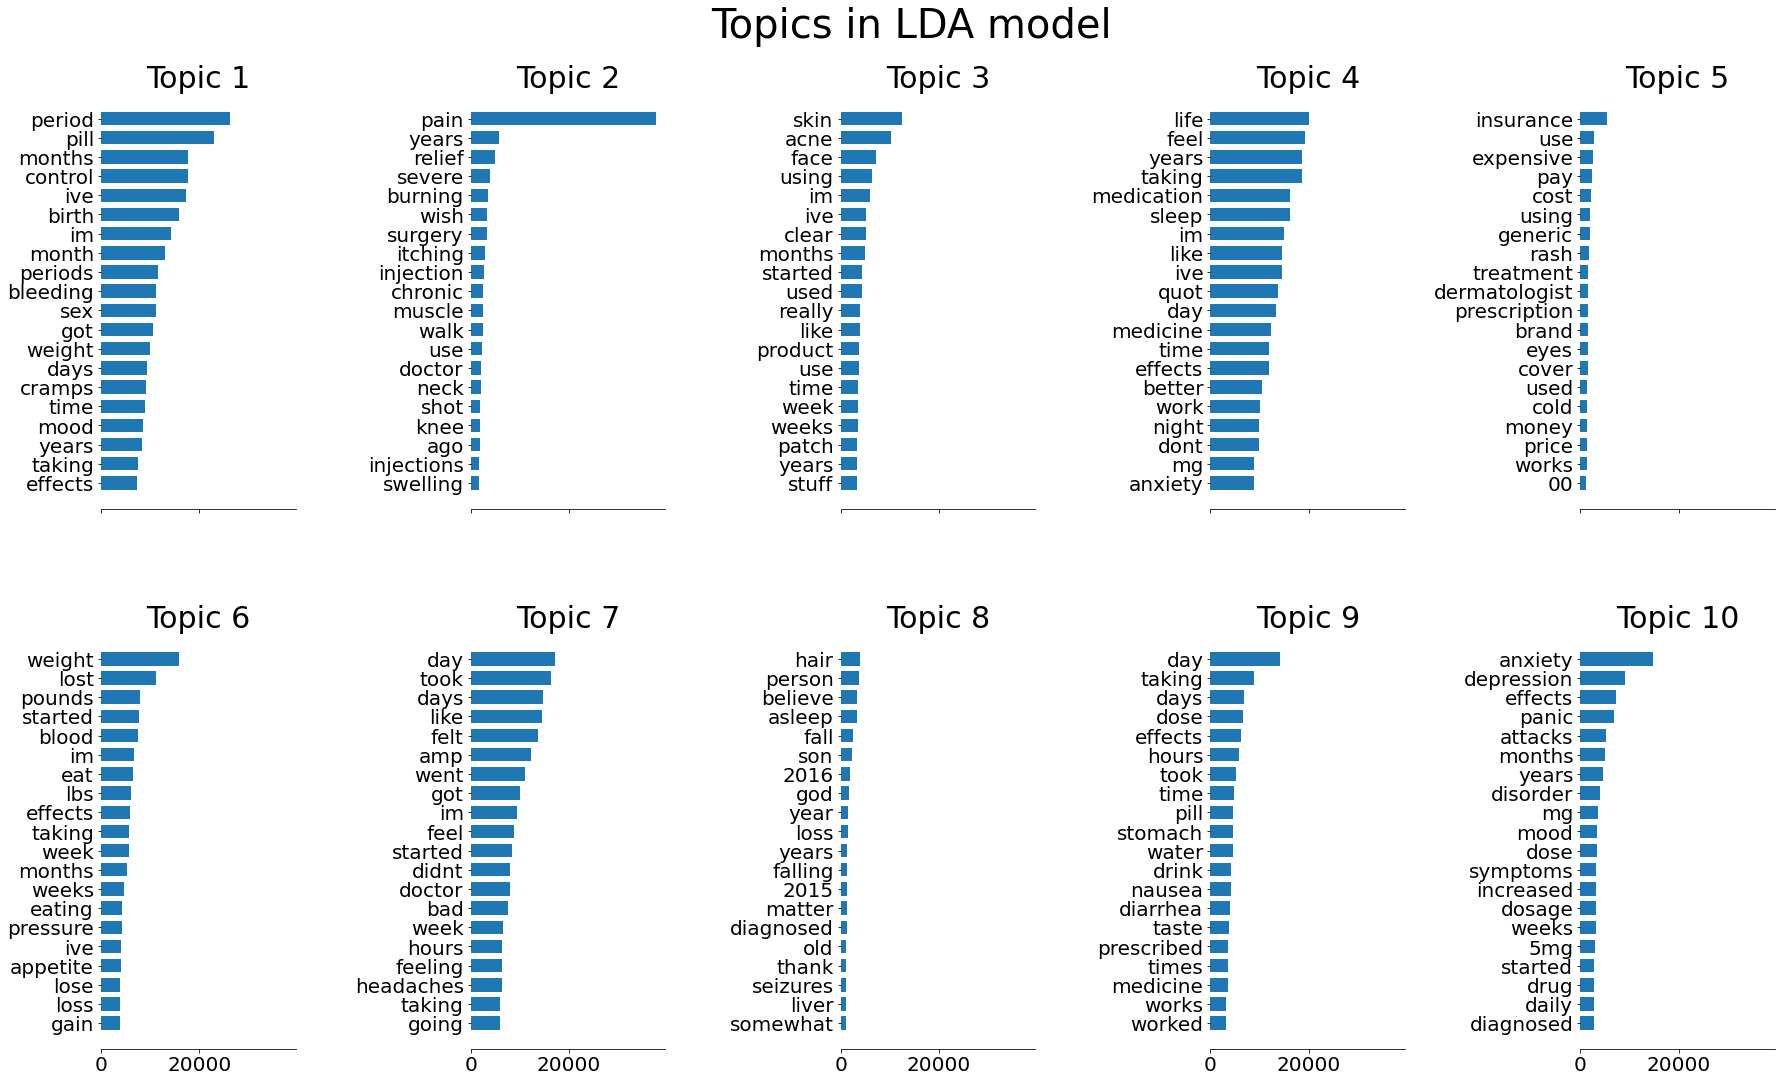

In [ ]:
n_top_words=20
plot_top_words(lda1, feat_names1, n_top_words, "Topics in LDA model")